# Using LAMMPS with iPython and Jupyter

LAMMPS can be run interactively using iPython easily. This tutorial shows how to set this up.

## Installation

1. Download the latest version of LAMMPS into a folder (we will calls this `$LAMMPS_DIR` from now on)
2. Compile LAMMPS as a shared library and enable PNG support
   ```bash
   cd $LAMMPS_DIR/src
   make yes-molecule
   python2 Make.py -m mpi -png -a file
   make mode=shlib auto
   ```

3. Create a python virtualenv
   ```bash
   virtualenv testing
   source testing/bin/activate
   ```

4. Inside the virtualenv install the lammps package
   ```
   (testing) cd $LAMMPS_DIR/python
   (testing) python install.py
   (testing) cd   # move to your working directory
   ```

5. Install jupyter and ipython in the virtualenv
   ```bash
   (testing) pip install ipython jupyter
   ```

6. Run jupyter notebook
   ```bash
   (testing) jupyter notebook
   ```

## Example

In [1]:
from lammps import lammps, LammpsIPythonWrapper

In [2]:
lmp = lammps()
L = LammpsIPythonWrapper(lmp)

In [3]:
# 2d circle of particles inside a box with LJ walls
import math

b = 0
x = 50
y = 20
d = 20

# careful not to slam into wall too hard

v = 0.3
w = 0.08
                
L.units("lj")
L.dimension(2)
L.atom_style("bond")
L.boundary("f f p")

L.lattice("hex", 0.85)
L.region("box", "block", 0, x, 0, y, -0.5, 0.5)
L.create_box(1, "box", "bond/types", 1, "extra/bond/per/atom", 6)
L.region("circle", "sphere", d/2.0+1.0, d/2.0/math.sqrt(3.0)+1, 0.0, d/2.0)
L.create_atoms(1, "region", "circle")
L.mass(1, 1.0)

L.velocity("all create 0.5 87287 loop geom")
L.velocity("all set", v, w, 0, "sum yes")

L.pair_style("lj/cut", 2.5)
L.pair_coeff(1, 1, 10.0, 1.0, 2.5)

L.bond_style("harmonic")
L.bond_coeff(1, 10.0, 1.2)

L.create_bonds("all", "all", 1, 1.0, 1.5)

L.neighbor(0.3, "bin")
L.neigh_modify("delay", 0, "every", 1, "check yes")

L.fix(1, "all", "nve")

L.fix(2, "all wall/lj93 xlo 0.0 1 1 2.5 xhi", x, "1 1 2.5")
L.fix(3, "all wall/lj93 ylo 0.0 1 1 2.5 yhi", y, "1 1 2.5")

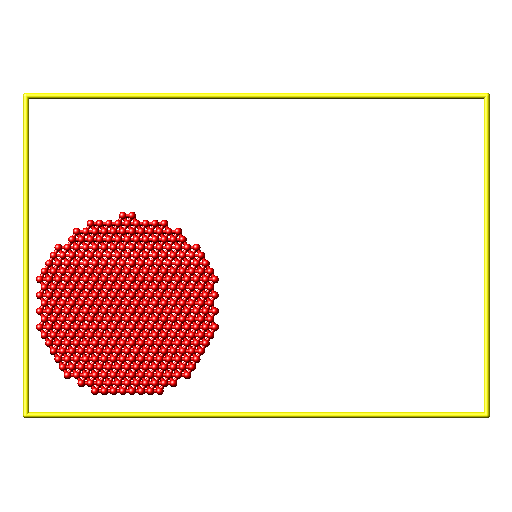

In [4]:
L.image(zoom=1.8)

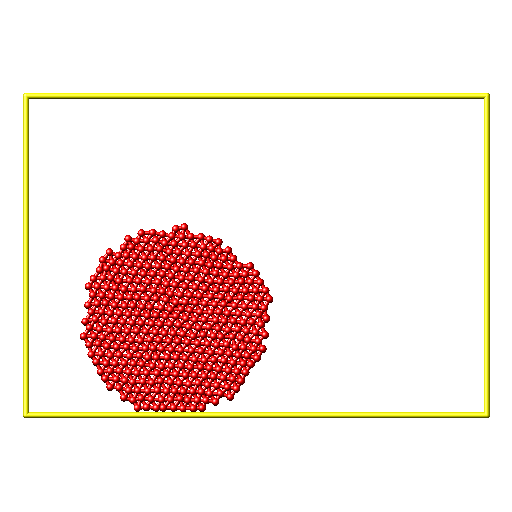

In [5]:
L.thermo_style("custom step temp epair press")
L.thermo(100)
output = L.run(40000)
L.image(zoom=1.8)

## Queries about LAMMPS simulation

In [6]:
L.system

System(nangles=0, atom_style='bond', style='lj/cut', nimpropertypes=0, zlo=-0.582767, orthogonal_box=[58.2767, 40.3753, 1.16553], natoms=361, dihedral_style='none', angle_style='none', xhi=58.2767, dimensions=2, improper_style='none', xlo=0.0, ntypes=1, atom_map='array', bond_style='harmonic', molecule_type='standard', nbondtypes=1, kspace_style='none', nangletypes=0, nimpropers=0, ylo=0.0, units='lj', yhi=40.3753, zhi=0.582767, ndihedrals=0, boundaries='f,f f,f p,p', nbonds=1014)

In [7]:
L.system.natoms

361

In [8]:
L.system.nbonds

1014

In [9]:
L.system.nbondtypes

1

In [10]:
L.communication

Communication(mpi_version='MPI v3.0', nprocs=1, ghost_velocity=False, comm_style='brick', comm_layout='uniform', nthreads=1, proc_grid=[1, 1, 1])

In [11]:
L.fixes

[{'group': 'all', 'name': '1', 'style': 'nve'},
 {'group': 'all', 'name': '2', 'style': 'wall/lj93'},
 {'group': 'all', 'name': '3', 'style': 'wall/lj93'}]

In [12]:
L.computes

[{'group': 'all', 'name': 'thermo_temp', 'style': 'temp'},
 {'group': 'all', 'name': 'thermo_press', 'style': 'pressure'},
 {'group': 'all', 'name': 'thermo_pe', 'style': 'pe'}]

In [13]:
L.dumps

[]

In [14]:
L.groups

[{'name': 'all', 'type': 'static'}]

## Working with LAMMPS Variables

In [15]:
L.variable("a index 2")

In [16]:
L.variables

{'a': <lammps.Variable at 0x7ffa2c48a5f8>}

In [17]:
L.variable("t equal temp")

In [18]:
L.variables

{'a': <lammps.Variable at 0x7ffa2c48a198>,
 't': <lammps.Variable at 0x7ffa2c48a550>}

In [19]:
float(L.print('"${a}"'))

2.0

In [20]:
L.variables['t'].value

0.363092663783386

In [21]:
L.eval("v_t/2.0")

0.181546331891693

In [22]:
L.variable("b index a b c")

In [23]:
L.variables['b'].value

'a'

In [24]:
L.eval("v_b")

0.0

In [25]:
L.variables['b'].definition

['a', 'b', 'c']

In [26]:
L.variable("i loop 10")

In [27]:
L.variables['i'].value

1.0

In [28]:
L.next("i")
L.variables['i'].value

2.0

In [29]:
L.eval("ke")

0.3620868669308006

## Accessing Atom data

In [30]:
L.atoms[0]

In [31]:
[x for x in dir(L.atoms[0]) if not x.startswith('__')]

['charge',
 'force',
 'id',
 'index',
 'lmp',
 'mass',
 'mol',
 'position',
 'type',
 'velocity']

In [32]:
L.atoms[0].position

(14.081609521719168, 0.920541427075243, 0.0)

In [33]:
L.atoms[0].id

1

In [34]:
L.atoms[0].velocity

(-0.08810676648167072, -0.8755151505832499, 0.0)

In [35]:
L.atoms[0].force

(0.809523377179948, -1.4360462290451692, 0.0)

In [36]:
L.atoms[0].type

1